## bpm_gibbs.py


The following is code for a Gibbs sampler for MCMC estimation of bipartite matching approach to record linkage.

## Bipartite matching approach to record linkage

Suppose that files $X_1$ and $X_2$ contain $n_1$ and $n_2$ records, respectively, and
without loss of generality that $n1 \geq n_2$. Denote also the number of entities represented in
both files as $n_{12}$, so that $n_2 \geq n_{12} \geq 0$.

The set of records coming from the two files can be represented as a *bipartite matching* and the parameter of interest is a matching matrix $\Delta$ of size $n_1\times n_2$ whose $(i,j)$th entry is defined as 

$$ \Delta_{ij} = \begin{cases} 1, & \text{ if records $i\in X_1$ and $j\in X_2$ refer to the same entity;} \\ 0, & \text{otherwise} \end{cases} $$

Sadinle (2017) uses a more compact representation called a *matching labeling*, which is useful when $n_1\times n_2$ is large.  Formally, the matching labeling is $Z = (Z_1, Z_2, \dots, Z_{n2})$, such that

$$ Z_j = \begin{cases} i, & \text{if records $i\in X_1$ and $j\in X_2$ refer to the same entity;} \\ n_1+j, & \text{if records $j\in X_2$ does not have a match in $X_1$ } \end{cases} $$

#### Advantages

#### Prior for $m$ and $u$ probabilities

It is expected that the probability of agreeing on an individual field of comparison is higher for matches than for nonmatches:

$$Pr(\gamma_{\ell}(a,b) = 1 |\ (a,b) \in M) > Pr(\gamma_{\ell}(a,b) = 1 |\ (a,b) \in U) $$ 

Use a dirichlet instead of independent betas. 

#### Beta Prior for Bipartite Matchings $Z$

This comes from Larsen (2005) and Sadinle (2017)/

Just as in the mixture model approach, the prior probability that $j \in X_2$ is:

$$ I(Z_j \leq n_1)  \overset{i.i.d}{\sim} \text{Bernoulli}(p_M)$$

where $p_M$ represents the proporiton of matches expected a priori as a fraction of the smallest file $X_2$.  Same as before, the hyperprior for $p_M$ is:

$$ p_M \sim \text{Beta}(\alpha_{M}, \beta_{M})$$ 

The prior on $p_M$ implies $n_{12}(Z) = \sum_{j=1}^{n_2} I(Z_j \leq n_1)$, the number of matches according to matching labeling $Z$ is distributed as:

$$n_{12}(Z) \sim \text{Beta-Binomial}(n_2, \alpha_{M}, \beta_{M}) $$ 

after marginalizing over $p_M$.

Conditioning on $\{I(Z_j \leq n_1)\}_{j=1}^{n_2}$, all possible bipartite matchings are taken to be equally likely, so $$Pr(Z\ |\ n_{12}) = \left(\frac{n_1!}{(n_1-n_{12})!}\right)^{-1}$$

These conditions imply the joint prior over $Z$:

$$Pr(Z\ |\ \alpha_M, \beta_M) = \frac{(n_1-n_{12}(Z))!}{n_1!}\frac{\text{Beta}(n_{12}(Z) + \alpha_M,\ n_2-n_{12}(Z) + \beta_M)}{\text{Beta}(\alpha_M, \beta_M)}$$





Finally 

$$\Gamma_{ij} | Z_j = i \overset{i.i.d}{\sim} M(m)$$

$$\Gamma_{ij}\ |\ Z_j \neq i \overset{i.i.d}{\sim} U(u) $$

$$ m_f \sim Dirichlet(\alpha_{\ell(0)}, \dots, \alpha_{\ell L}) $$

### Gibbs Sampler

Initialize match/nonmatch configuration $Z$. Tricks to do this.

1. Draw $p_M$ from $$ p_M\ |\ Z \sim \text{Beta}(\alpha_M + n_{M}(Z),\ \beta_M + n_{2} - n_{M}(Z)) $$ Note this is same as before. 

2. Draw $p_{M\ell}$ and $p_{U\ell}$ from their conditional distributions (same as before).

3. Use Metropolis-Hastings algorithm to draw values of $Z$ and $n_{12}(Z)$ from their full conditional distributions.  

The only difference is step 3! $I$ is no longer a bunch of Bernoullis, and assignment of $I(a,b)$ will now affect $I(a',b')$ which is desirable. 

### Python setup

In [2]:
import numpy as np
import scipy
from scipy.stats import binom

%matplotlib inline
from seaborn import plt
import pandas as pd 
import itertools

plt.rcParams['figure.figsize'] = (10, 5)

### 1. Updates for $p_M$


In [444]:
def sample_pM(s, aM, bM):
    aNew = aM + s.nM
    bNew = bM + n2 - s.nM
    if ((aNew <= 0) or (bNew <=0)): print('neg. beta param')
    return np.random.beta(aNew,bNew)

### 2. Updates for $p_{M\ell},\ p_{U\ell}$

In [446]:
def sample_pML(s, aML, bML):
    assert n2 == len(s.Z), 'Z got messed up'
    ones = np.array([1] * L)
    aSums = np.zeros(L)
    bSums = np.zeros(L)
    for x2 in s.matchedX2:
        matchInd = Gamma.index[(Gamma['i']==x2)&(Gamma['j']==s.Z[x2])].tolist()
        for y in matchInd:
            aSums += Gamma.loc[y]['gamma']
            bSums += (ones-Gamma.loc[y]['gamma'])
    aNew = aML + aSums
    bNew = bML + bSums
    if ((any(a <= 0 for a in aNew)) or (any(b <= 0 for b in bNew))): print('neg. beta param')
    return np.random.beta(aNew, bNew)

def sample_pUL(s, aUL, bUL):
    assert n2 == len(s.Z), 'Z got messed up'
    ones = np.array([1] * L)
    aSums = np.zeros(L)
    bSums = np.zeros(L)
    for x2 in range(n2):
        nonMatchInd = Gamma.index[(Gamma['i']==x2)&(Gamma['j']!=s.Z[x2])].tolist()
        for y in nonMatchInd:
            aSums += Gamma.loc[y]['gamma']
            bSums += (ones-Gamma.loc[y]['gamma'])
    aNew = aUL + aSums
    bNew = bUL + bSums
    if ((any(a <= 0 for a in aNew)) or (any(b <= 0 for b in bNew))): print('neg. beta param')
    return np.random.beta(aNew, bNew)

### 3. Updates for $Z, n_M$ 

These rely on many helper functions but below is a function that chooses the move type at random.

### Move #1: $\ n_m^* = n_m - 1$

Pick a record $j$ at random from the set of matched records $\{j: Z_j \leq n_{1}\}$ (with equal probability). 

In [447]:
def move_1(s, pM, pML, pUL):
    
    assert len(s.matchedX2) == s.nM, 'nM is not calibrated correctly'
    assert len(s.matchedX2) == len(s.matchedX1), 'not bipartite matching'
    
    old_state = make_state(s.Z, pM, pML, pUL) # save current Z
    Z_new = old_state.Z
    
    if (len(old_state.matchedX2) == 0):  # no matches to remove, try another move
        return old_state
    
    #option 1 - randomly select i in matchedX2 and set to non-match 

    i = old_state.matchedX2[np.random.choice(old_state.nM)] # randomly select i in X2
    Z_new[i] = i + n1                          # set i's status to non-match in Z
    new_state = make_state(Z_new,pM, pML, pUL)              # make proposal state
    
    # calculate jump probability pMH
    const = np.log(old_state.nM/((n1-old_state.nM+1)*(n2-old_state.nM+1))) 

    pMH = min(1, np.exp(new_state.llh+const-old_state.llh))
#     print('prob of jump is ' + str(pMH))
    
    accept = np.random.binomial(1, pMH)     # choose jump or not
    
    if accept == 1:  
        return new_state
    else:            
        return old_state

### Move #2: $\ n_m^* = n_m + 1$

Pick a record $j$ at random from the set of unmatched records $\{j: Z_j > n_{1}\}$ (with equal probability). 

NOT SURE IF CORRECT YET

In [448]:
def move_2(s, pM, pML, pUL):
    
    assert len(s.matchedX2) == s.nM, 'nM is not calibrated correctly'
    assert len(s.matchedX2) == len(s.matchedX1), 'not bipartite matching'
    
    old_state = make_state(s.Z, pM, pML, pUL) # save current Z, fix any bugs
    Z_new = old_state.Z
    
    if (len(old_state.unmatchedX2) == 0) or (len(old_state.unmatchedX1) == 0): # nothing to match
        return old_state
    
    # option 1 - randomly select which record pair to add

    addX2 = old_state.unmatchedX2[np.random.choice(len(old_state.unmatchedX2))] # randomly pick record to give match
    addX1 = old_state.unmatchedX1[np.random.choice(len(old_state.unmatchedX1))] # randomly pick its match
    
    Z_new[addX2] = addX1                                         # assign new match 
    new_state = make_state(Z_new, pM, pML, pUL)                                # make proposal state

    # calculate probability of jump
    const = np.log((n1-old_state.nM)*(n2-old_state.nM)/(old_state.nM+1))
        
    pMH = min(1, np.exp(new_state.llh+const-old_state.llh))
#     print('prob of jump is ' + str(pMH))
    
    accept = np.random.binomial(1, pMH)
    
    if accept == 1:
         return new_state  
    else:
        return old_state

### Move #3: $\ n_M$ changed, but $Z$ altered

#### Variation 1: Two matches switch pairings

In [449]:
def move_3_v1(s, pM, pML, pUL):
    
    assert len(s.matchedX2) == s.nM, 'nM is not calibrated correctly'
    assert len(s.matchedX2) == len(s.matchedX1), 'not bipartite matching'
    
    old_state = make_state(s.Z, pM, pML, pUL) # save current Z, fix any bugs
    
    if old_state.nM < 2:
        # nothing to switch
        return old_state
    
    #Randomly select 2 matched pairs with prob 2/nm(nm-1)
    (i,k) = np.random.choice(old_state.nM, size=2, replace=False, p=None)
    j = old_state.Z[old_state.matchedX2[i]]
    l = old_state.Z[old_state.matchedX2[k]]
    
    # calculate jump probability pMH
    pMH = calc_pMH_move3(i,j,k,l, pML, pUL)
    
#     print('prob of jump is ' + str(pMH))
    accept = np.random.binomial(1, pMH)
    
    if accept == 1:
        # flip entries in Z
        old_state.Z[old_state.matchedX2[i]] = l
        old_state.Z[old_state.matchedX2[k]] = j
        new_state = make_state(old_state.Z, pM, pML, pUL)
        return new_state
        
    else:
        return old_state
    
def calc_pMH_move3(i, j, k, l, pML, pUL):
    gamma_il = Gamma[(Gamma['i']==int(i)) & (Gamma['j']==int(l))]['gamma'].values[0]
    gamma_kj = Gamma[(Gamma['i']==int(k)) & (Gamma['j']==int(j))]['gamma'].values[0]
    gamma_ij = Gamma[(Gamma['i']==i) & (Gamma['j']==j)]['gamma'].values[0]
    gamma_kl = Gamma[(Gamma['i']==k) & (Gamma['j']==l)]['gamma'].values[0]
    num = calc_pGammaM(gamma_il, pML)+calc_pGammaM(gamma_kj, pML) +\
            calc_pGammaU(gamma_ij, pUL)+calc_pGammaU(gamma_kl, pUL)
    denom = calc_pGammaM(gamma_ij, pML)+calc_pGammaM(gamma_kl, pML) +\
            calc_pGammaU(gamma_il, pUL)+calc_pGammaU(gamma_kj, pUL)
    return min(1, np.exp(num-denom))

#### Variation 2:   Matched pair replaces one of its matching records with nonmatching record

In [450]:
def move_3_v2(s, pM, pML, pUL):
    
    old_state = make_state(s.Z, pM, pML, pUL) 
    
    assert len(old_state.matchedX2) == old_state.nM, 'nM is not calibrated correctly'
    assert len(old_state.matchedX2) == len(old_state.matchedX1), 'not bipartite matching'
    
    if (len(old_state.unmatchedX1) == 0) and (len(old_state.unmatchedX2)==0):  # impossible to switch
        return old_state 
    
    if (old_state.nM == 0):
        return old_state # no pairs to replace
    
    if (len(old_state.unmatchedX1) == 0):  # not possible to switch x2's partner
            file == 1
    
    elif (len(old_state.unmatchedX2)==0):  # not possible to switch x1's partner
            file ==2
    
    else:  # randomly select x1 or x2 to switch its partner
        file = np.random.randint(2) + 1   
    
    # Randomly select matchedX2, unmatchedX1, and match them
    
    if file == 1:  # randomly select a file from x1 and replace its partner 
        j = old_state.matchedX1[np.random.randint(old_state.nM)]
        l = old_state.unmatchedX2[np.random.randint(len(old_state.unmatchedX2))]    
        i = [i for i, val in enumerate(old_state.Z) if val == j][0]
        
    elif file == 2: # randomly select a file from x2 and replace its partner
        i = old_state.matchedX2[np.random.randint(old_state.nM)]
        l = old_state.unmatchedX1[np.random.randint(len(old_state.unmatchedX1))]    
        j = old_state.Z[i]

    # calculate jump probability pMH
    pMH = calc_pMH_move3_v2(i,j,l, pML, pUL)
    
#     print('prob of jump is ' + str(pMH))
    accept = np.random.binomial(1, pMH)
    
    if accept == 1:
        Z_new = old_state.Z
        if file == 1: # fix X1's partner
            Z_new[i] = n1 + i # unmatch old X2 partner
            Z_new[l] = j      # add new partner
        elif file == 2: # update X2's partner
            Z_new[i] = l 
        
        new_state = make_state(Z_new, pM, pML, pUL)
        return new_state
        
    else:
        return old_state
    
def calc_pMH_move3_v2(i,j,l, pML, pUL):
    gamma_il = Gamma[(Gamma['i']==int(i)) & (Gamma['j']==int(l))]['gamma'].values[0]
    gamma_ij = Gamma[(Gamma['i']==int(i)) & (Gamma['j']==int(j))]['gamma'].values[0]
    num = calc_pGammaM(gamma_il, pML)+calc_pGammaU(gamma_ij, pUL) 
    denom = calc_pGammaM(gamma_ij, pML)+calc_pGammaU(gamma_il, pUL)
    return min(1, np.exp(num-denom))

#### Variation 3:   One matched pair is deleted and two unmatched records are paired

NEED TO FIGURE OUT JUMP PROBABILITY

In [451]:
def move_3_v3(s, pM, pML, pUL):
    
    old_state = make_state(s.Z, pM, pML, pUL) # save current Z
    
    assert len(old_state.matchedX2) == old_state.nM, 'nM is not calibrated correctly'
    assert len(old_state.matchedX2) == len(old_state.matchedX1), 'not bipartite matching'
    
    if (len(old_state.matchedX2) == 0) or (len(old_state.unmatchedX2) == 0):  # no matches to remove, try another move
        return old_state
    
    if (len(old_state.matchedX1) == 0) or (len(old_state.unmatchedX1) == 0):  # no matches to remove, try another move
        return old_state
    
    #randomly select i in matchedX2 and set to non-match 

    i = old_state.matchedX2[np.random.choice(old_state.nM)] # randomly select i in X2
    unmatchedX1 = old_state.unmatchedX1 + [old_state.Z[i]]  # free old match
    newZ = old_state.Z
    newZ[i] = i + n1                          # set i's status to non-match in Z
    
    # randomly select j in unmatched X2 and set to match 
    addX2 = old_state.unmatchedX2[np.random.choice(len(old_state.unmatchedX2))]
    j = unmatchedX1[np.random.choice(len(unmatchedX1))]
    newZ[addX2] = j                               
    
    new_state = make_state(newZ, pM, pML, pUL)              # make proposal state

    # calculate jump probability
    const = np.log(old_state.nM/((n1-old_state.nM)*(n2-old_state.nM)))
    pMH = min(1, np.exp(new_state.llh + const - old_state.llh))
    
#     print('prob of jump is ' + str(pMH))
                                                  
    # choose jump or not
    accept = np.random.binomial(1, pMH)
    
    if accept == 1:  
        return new_state
        
    else:            
        return old_state
    

### Maintaining $Z$ 

In [452]:
class State(object):
    matchedX2 = []
    unmatchedX2 = []
    matchedX1 = []
    unmatchedX1 = []
    Z = []
    nM = 0
    llh = 1
    
    def __init__(self,Z):
        
        self.matchedX2 = [i for i in range(n2) if Z[i] < n1]
        self.matchedX1 = [i for i in Z if i < n1]
        self.nM = len(self.matchedX2)
        self.unmatchedX2 = np.delete([i for i in range(n2)], self.matchedX2)
        self.unmatchedX1 = [i for i in range(n1) if i not in Z]
        self.Z = Z

        if len(Z) != len(np.unique(Z)): 
            print_state(self)
            
        assert len(Z) == n2, 'invalid bpm'
        assert len(Z) == len(np.unique(Z)), 'invalid bpm'
               
def make_state(Z, pM, pML, pUL):
    state = State(Z)
    state.llh = calc_pNM_Z(state, pM, pML, pUL)
    return state

def print_state(s):
    print('Z: ' + str(s.Z))
    print('matchedX2: ' + str(s.matchedX2))
    print('matchedX1: ' + str(s.matchedX1))
    print('unmatchedX2: ' + str(s.unmatchedX2))
    print('unmatchedX1: ' + str(s.unmatchedX1))
    return

In [453]:
# Functions for evaluating log llh of Z
# BDA3 says jump probabilities should be exp(diff in log density) 

def calc_pGammaM(gammaInd,pML):
    # returns log(pGamma_ij | M)
    assert len(gammaInd) == len(pML), 'dim do not match'
    return np.sum([gammaInd[l]*np.log(pML[l]) + (1-gammaInd[l])*np.log(1-pML[l]) for l in range(len(pML))])

def calc_pGammaU(gammaInd,pUL):
    # returns log(pGamma_ij | U)
    assert len(gammaInd) == len(pUL), 'dim do not match'
    return np.prod([(pUL[l]**gammaInd[l])*(1-pUL[l])**(1-gammaInd[l]) for l in range(len(pML))])

def calc_pGamma(s, pM, pML, pUL):
    # calculates log P(gamma | Z, pML, pUL) for ENTIRE gamma (which has n1*n2 entries)
    pGamma = 0
    for index, row in Gamma.iterrows():
        if row['j'] == s.Z[row['i']]:
            pGamma += calc_pGammaM(row['gamma'],pML)
        else:
            pGamma += calc_pGammaU(row['gamma'],pUL)        
    return pGamma

def calc_pNM_Z(s, pM, pML, pUL):
    #returns log P(nM, Z | current params) ~ log P(nM | pM) + log P(Z | nM) + log P(gamma | all param, Z) 
    pNM = np.log(binom.pmf(s.nM, n2, pM))  # p(nM | pM) ~ Binom(nM successes out of n2, w/ param pM)
    pZ = np.log(scipy.math.factorial(n1-s.nM)/scipy.math.factorial(n1))
    pGamma = calc_pGamma(s, pM, pML, pUL) 
    
    return pNM + pZ + pGamma

### Writing the Gibbs sampler

In [454]:
## specify initial values
L=10
init = {"pM": 0.5,
        "pML": [0.5]*L,
        "pUL": [0.5]*L}

## specify hyper parameters 
hypers = {"aM": 1,
          "bM": 1,
          "aML": [1]*L,
          "bML": [1]*L,
          "aUL": [1]*L,
          "bUL": [1]*L}

def check_valid_prior(init):
    assert (init["pM"] < 1) and (init['pM'] > 0), 'pM must be between 0,1'
    assert (0 not in init['pML']) and (1 not in init['pML']), 'elements of pML must be b/w 0,1'
    assert (0 not in init['pUL']) and (1 not in init['pUL']), 'elements of pML must be b/w 0,1'
    return 

In [455]:
def gibbs(Gamma, iters, init, hypers, Z_init):
    # some assertions needed here
    assert len(init["pML"]) == len(init["pUL"]), 'dimensions of pML and pUL do not match'
    
    pM = init["pM"]
    pML = init["pML"]
    pUL = init["pUL"]
    nPar = 1 + len(pML) + len(pUL) 
    
    L = len(pML)
    numPair = Gamma.shape[0]
    
    trace = np.zeros((iters,nPar+1)) 
    Z_trace = np.zeros((iters,n2)) 
    
    #initialize global state vars
    state = make_state(Z_init, pM, pML, pUL)
 
    for it in range(iters):
   
        # 1. Draw pM | Z ~ Beta(aM + nM(Z), bM + n2 - nM(Z)) 
        pM = sample_pM(state, hypers['aM'], hypers['bM']) 
        
        # 2. Draw pML | Z, pUL | Z
        gamma = Gamma['gamma']
        pML = sample_pML(state, hypers['aML'], hypers['bML'])
        pUL = sample_pUL(state, hypers['aUL'], hypers['bUL'])
        
        # 3. Draw values of Z (update state)
        moveType = np.random.randint(3) + 1
        if moveType == 3:
            m3 = np.random.randint(3) + 1
            moveType = '3_v' + str(m3)
        move = 'move_' + str(moveType) + '(state, pM, pML, pUL)'
#         print('move' + str(moveType))
        state = eval(move)
        
        trace[it,:] = np.append(np.append(np.append(pM, pML),pUL),state.llh) # update trace
        Z_trace[it, :] = state.Z
            
    trace = pd.DataFrame(trace)
    Z_trace = pd.DataFrame(Z_trace)
    Z_trace = Z_trace.astype(int)
    
    pML_names = ['pML_' + str(i) for i in range(1,L+1)]
    pUL_names = ['pUL_' + str(i) for i in range(1,L+1)]
    trace.columns= ['pM'] + pML_names + pUL_names + ['llh']
    return trace, Z_trace

### Likelihood functions

The functions below are used to evaluate the (non-normalized) posterior conditional distribution of $(n_{M}, Z)$ given the current parameter values according to:

$$ Pr(n_{M}, Z\ |\ \Gamma, \{p_{M\ell}, p_{U\ell}, \ell = 1,\dots,L \}, p_M, \alpha, \beta) \propto P(n_{M}\ |\ p_M) P(Z\ |\ n_{M}) P(\Gamma\ |\ Z, \{p_{M\ell}, p_{U\ell}, \ell = 1,\dots,L \}) $$

where $P(\Gamma\ |\ Z, etc.)$ = that annoying thing. 

In principle we could enumerate all possible $Z$ but that would be huge.  So instead we draw new values of $n_{12}^*, I^*$ incrementally. 



### Synthetic Data
#### Function for making synthetic data

In [456]:
from recordlinkage import datasets

def make_Gamma(n1, n2, pM, pML, pUL):
    nPair = n1 * n2
    L = len(pML)
    gamma=np.array(datasets.binary_vectors(nPair, int(pM*nPair), m=pML, u = pUL, random_state=113))
    i = [[i]*n1 for i in range(n2)]
    iVals = []
    for x in i:
        iVals += x
    jVals = [j for j in range(n1)] * n2
    Gamma = pd.DataFrame(
        {'gamma': [list(gamma[i]) for i in range(len(gamma))],
        'i': iVals, 
        'j': jVals})
    return Gamma

def make_Z_init(n1,n2):
    Z = [n1 + i for i in range(n2)]
    matchX1 = np.random.choice([i for i in range(n1)], size=int(.5*n2), replace=False, p=None)
    matchX2 = np.random.choice([i for i in range(n2)], size=int(.5*n2), replace=False, p=None)
    for i,x2 in enumerate(matchX2):
        Z[x2] = matchX1[i]
    return Z

In [470]:
n1 = n2 = 10
pML = [.7] * 10
pUL = [.2] * 10 
pM = .5

Gamma = make_Gamma(n1,n2,pM,pML,pUL)
Z_init = make_Z_init(n1,n2)

In [471]:
import time
start = time.time()
trace, Z_trace = gibbs(Gamma, 10, init, hypers, Z_init)
end = time.time()
print(end-start)



0.7972919940948486


In [465]:
def make_file_names(nPair, L):
    zName = 'Z_trace_nPair' + str(n1*n2) + '_cat' + str(L)
    traceName = 'trace_nPair' + str(n1*n2) + '_cat' + str(L)
    return (zName, traceName)

zName, traceName = make_file_names(n1*n2, L)
Z_trace.to_csv(zName+'.csv', mode='w')
trace.to_csv(traceName+'.csv', mode='w')

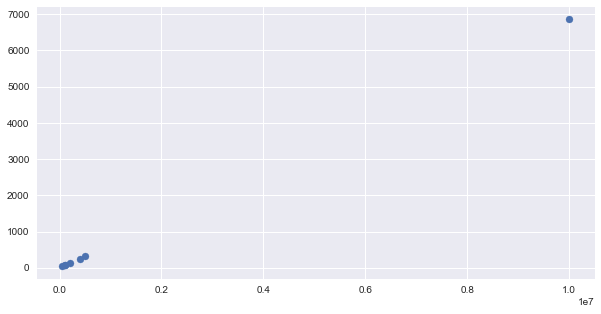

In [4]:
data = {'nPair': [100,100, 100, 100, 400, 10000,10000], 'nits': [500, 1000, 2000, 100000, 1000, 10, 50], 'time': [37, 72, 142, 6860, 254, 65, 325]}
df = pd.DataFrame(data)
fig = plt.scatter(df.nPair*df.nits, df.time)


Runtime is linear in $niter\times nPair$!

In [3]:
import matplotlib.pyplot as plt
plt.plot(trace.llh)


NameError: name 'trace' is not defined

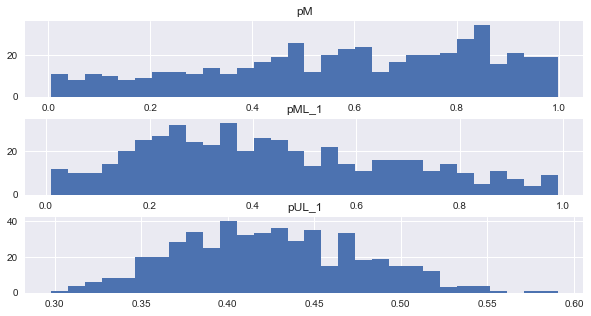

In [462]:
trace_burnt = trace
hist_plot = trace_burnt[['pM','pML_1','pUL_1']].hist(bins=30,layout=(3,1))

In [ ]:
from recordlinkage import datasets
import numpy as np
import pandas as pd
pM = 0.5
nPair=100
pML = [0.8, 0.8, 0.8]
pUL = [0.2, 0.2, 0.2]
Gamma, links = datasets.binary_vectors(nPair, int(pM*nPair), m=pML, u = pUL, random_state=113, return_links=True)

In [240]:
from recordlinkage import datasets
import numpy as np
import pandas as pd

def make_fake_data(n1, n2, pM, pML, pUL, randState = 113):
    nPair = n1 * n2
    L = len(pML)
    gamma, links =np.array(datasets.binary_vectors(nPair, int(pM*nPair), \
                m=pML, u = pUL, random_state=randState, return_links = True))
    
    gamma['match'] = False
    gamma.loc[links,'match']= True
    matches = gamma['match']
    # make pair identifiers 
    i = [[i]*n1 for i in range(n2)]
    iVals = []
    for x in i:
        iVals += x
    jVals = [j for j in range(n1)] * n2
    
    # make true link column
    true_links = pd.DataFrame(links)
    true_links[['iTrue','jTrue']] = temp.apply(pd.Series)
    true_links = true_links[['iTrue','jTrue']]
    
    Gamma = pd.DataFrame(
        {'gamma': list(gamma[['c_1','c_2','c_3']].values),
        'i': iVals,
        'j': jVals,
        'match': matches})
    Gamma = Gamma.reset_index(drop=True)
    return Gamma


In [241]:
make_fake_data(n1, n2, pM, pML, pUL, randState = 113)

,gamma,i,j,match
0,"[1, 1, 0]",0,0,False
1,"[0, 0, 1]",0,1,False
2,"[0, 0, 0]",0,2,False
3,"[1, 1, 1]",0,3,True
4,"[1, 1, 0]",0,4,False
5,"[0, 1, 1]",0,5,True
6,"[0, 0, 0]",0,6,False
7,"[1, 0, 1]",0,7,True
8,"[1, 1, 1]",0,8,True
9,"[1, 1, 1]",0,9,True
